# Tensorflow input

There are a number of ways of importing data into Tensorflow. They can be read file-by-file from disk, loaded into RAM and read from serialized files.<br>
Generally, one starts simple, but for our purposes we will use a serialized format called tfrecord.<br><br>

Lets use a few images from the dataset as our test data. 

## 1. Loading and showing

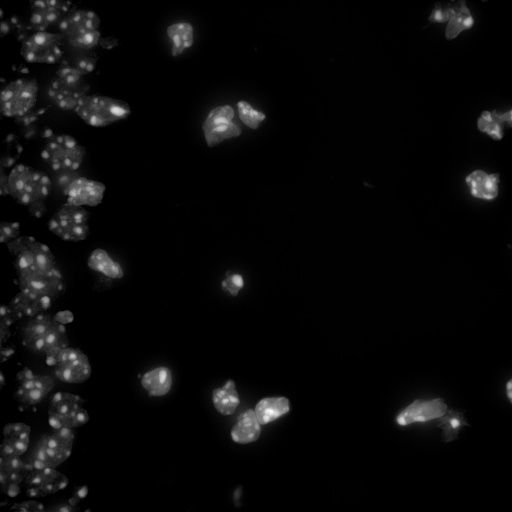

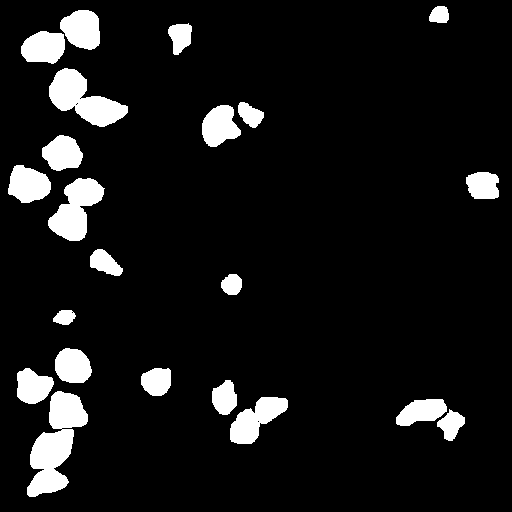

In [167]:
from io import BytesIO
from PIL import Image
import os
from IPython.display import Image as IpImage
from IPython.display import display

def show_fig(ima, scale=None):
  if isinstance(ima, str):
    img = Image.open(ima)
    image_size = img.size
    if scale:
      size = tuple([int(dim * scale) for dim in image_size])
      img = img.resize(size, Image.NEAREST)
  else:
    img = Image.fromarray(ima)
  bio = BytesIO()
  img.save(bio, format='png')
  display(IpImage(bio.getvalue(), format='png'))


# from PIL import Image
image_files = [
  './data/Nuclei_0.png',
  './data/Nuclei_2.png',
  './data/Nuclei_3.png',
]
label_files = [
  './data/Nuclei_0_ROIs_label.png',
  './data/Nuclei_2_ROIs_label.png',
  './data/Nuclei_3_ROIs_label.png',
]

show_fig(image_files[0], 0.25)
show_fig(label_files[0], 0.25)

Perfect, now, we will define a method that loads an image from a path, resizes it to the desired size and returns the array.

In [168]:
def load_image(img_path, size=(), scale=None, interpolation=Image.NEAREST):
    """Load an image as an 2D/3D array, perform resizing if desired.

    Parameters
    ----------
    img_path : str
        Path to the image in question
    size : tuple, optional
        Desired output size of the image
    scale : float/None, optional
        Desired rescaling of the image
    interpolation : ANTIALIAS, optional
        Desired interpolation to use for resizing

    Returns
    -------
    np.array
        The image in numpy array format
    np.array
        The shape of said image
    """
    img = Image.open(img_path)
    if scale:
        image_size = img.size
        size = tuple([int(dim * scale) for dim in image_size])

    if size:
        img = img.resize(size, interpolation)
    arr = np.array(img)

    arr_shape = arr.shape
    if len(arr.shape) == 2:
        arr_shape = (arr_shape[0], arr_shape[1], 1)
    return arr, arr_shape

Lets test it on our images.

The loaded image is (2048, 2048)
The loaded image is (1024, 1024)
The loaded image is (244, 244)


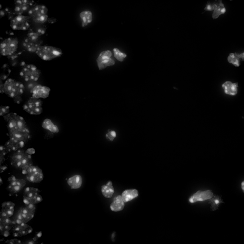

In [169]:
img_array, _ = load_image(image_files[0])
print("The loaded image is {}".format(img_array.shape))
img_array, _ = load_image(image_files[0], scale=0.5)
print("The loaded image is {}".format(img_array.shape))
img_array, _ = load_image(image_files[0], size=(244, 244))
print("The loaded image is {}".format(img_array.shape))
show_fig(img_array)

## 2. Parsing to tf Example
Each sample within a tfrecord is composed of tf.train.Example which inturn is composed of list of Features which is further composed of bytes. We need to make sure that we use the correct bytes during decoding AND encoding.<br>
We begin by creating our conversion functions, that take in bytes from from numpy to be converted to list of bytes.

In [170]:
import tensorflow as tf

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# We dont really need this one, but I'll leave it here for brevity.
# NOTE: You cannot put in a array of floats as one can with array of int64.
def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
  
# A small test
img_array, _ = load_image(image_files[0], size=(244, 244))
bytes_feature = _bytes_feature(img_array.tostring())
int_64_feature = _int64_feature(10)

Now, we can begin creating our training example. Lets create a method that takes in an image path, loads it and generate the tf.train.Example

In [171]:
def get_train_example(image_path, label_path, size=(244, 244), print_text=False):
  img_array, img_shape = load_image(image_path, size=size)
  lbl_array, lbl_shape = load_image(label_path, size=size)

  h, w, d = img_shape

  if print_text:
    print("The dataformat of the image is {}".format(img_array.dtype))
    print("The dataformat of the mask is {}".format(lbl_array.dtype))
    print("The shape of the image is {}".format(img_array.shape))
    print("The shape of the mask is {}".format(lbl_array.shape))

  example = tf.train.Example(features=tf.train.Features(feature={
      'height': _int64_feature(h),
      'width': _int64_feature(w),
      'depth': _int64_feature(d),
      # store data
      'image': _bytes_feature(img_array.tostring()),
      'mask': _bytes_feature(lbl_array.tostring())
  }))
  
  return example

# And test it
examp = get_train_example(image_files[0], label_files[0], print_text=True)

The dataformat of the image is uint8
The dataformat of the mask is uint8
The shape of the image is (244, 244)
The shape of the mask is (244, 244)


Perfect! Now onto creating the tfrecord itself!

## 3. Creating a tfrecord
The procedure here is rather straightforward. Loop through all examples, get the example, write to the file and close the writer. <br>
It is however not good to put ALL data into one giant tfrecord, but rather split them up into a shards of tfrecords. This is left as an excercise.

In [172]:
import os
def create_tfrecord(img_paths, lbl_paths, name, store_dir, size=(244, 244)):
  """Generate tfrecords given the list of paths.

  Parameters
  ----------
  img_paths : list
      List of image paths
  lbl_paths : list
      List of mask paths
  name      : str
      What name to give this tfrecord
  store_dir : str
      Which directory to store this tf record in
  size: tuple
      Desired size to store the images as
  """
  if not os.path.exists(store_dir):
    os.makedirs(store_dir)

  filename = os.path.join(store_dir, "%s.tfrecord" % name)
  writer = tf.python_io.TFRecordWriter(filename)

  for img_path, lbl_path in zip(img_paths, lbl_paths):
    example = get_train_example(img_path, lbl_path, size=size)
    writer.write(example.SerializeToString())
  writer.close()
  
  print("Sucessfully created %s!" % filename)

create_tfrecord(image_files, label_files, 'my_first_record', os.getcwd())

Sucessfully created /content/carvana_gcp/IPython/WP2/my_first_record.tfrecord!


# 4.Reading a tfrecord
There are of course a number of ways of reading a tfrecord file. But here I will simply introduce tf.data.Dataset.<br>.
This is a class that rather neatly takes care of looping through the tfrecords, parsing them and returning the samples. It also has the added benefit of easily integrating with Tensorflows Estimator's (Later).<br>

First we must create a parser for our training examples. This is essence a translator from serialized to usable data.

In [173]:
def parse_single_example(record):
    """Parses a single example."""
    feature = {'height': tf.FixedLenFeature([], tf.int64),
               'width': tf.FixedLenFeature([], tf.int64),
               'depth': tf.FixedLenFeature([], tf.int64),
               'image': tf.FixedLenFeature([], tf.string),
               'mask': tf.FixedLenFeature([], tf.string)
               }

    return tf.parse_single_example(record, feature)

Next, we create a parser that is able to take a complete record and parse the examples into a format we want to train with. Here is the part where it is VERY important to know what the dataformat was used when creating the tfrecord. <br>
Thus, we say that to decode the raw data, image should be a tf.uint8 and mask is a boolean. <br>

This is also the perfect place to do any pre-processing of your images, like normalizing etc.


In [174]:
def read_and_decode(record, shape=[244, 244]):
  """Reads and decodes a tfrecord-file. """
  parsed = parse_single_example(record)

  # shape of image and annotation
  img_shape = shape
  mask_shape = shape

  # read, decode and normalize image
  image = tf.decode_raw(parsed['image'], tf.uint8)
  image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
  image = tf.reshape(image, img_shape)

  mask = tf.decode_raw(parsed['mask'], tf.uint8)
  mask = tf.cast(mask, tf.int32)
  mask = tf.reshape(mask, mask_shape)

  return image, mask

Next we create the "Feeder" method creator. The reason it's wrapped within a method is because we will be using estimators later.<br>
An Estimator __must__ be the only one creating nodes onto a graph, otherwise you will run into issues that parts of your graph can lie outside your maingraph.<br>

Giving the Estimator the method feeder, will allow the estimator to call the feeder method when ready, and under the correct graph.

__NOTE:__ Here we hardocde the buffersize, num_parallel_calls, batch_size simply for convenince. Normally these are tunable parameters.

In [175]:
def get_feeder_method(filenames, img_sizes=[244, 244]):
  """Create a dataset feeder method."""
  def feeder():
    # Give this a list of tfrecords to loop through
    dataset = tf.data.TFRecordDataset(filenames)

    def parser(record):
        return read_and_decode(record, img_sizes)

    dataset = dataset.map(parser, num_parallel_calls=1)
    dataset = dataset.shuffle(buffer_size=1)
    dataset = dataset.batch(1)
    if False:
      dataset = dataset.repeat()  # No repeats for this demo


    iterator = dataset.make_one_shot_iterator()
    image, mask = iterator.get_next()
    
    features = {'image': image}
    labels = {'mask': mask}

    return features, labels
  return feeder


Let's test our feeder method. We call the method, then call the feeder method and run it within a session.

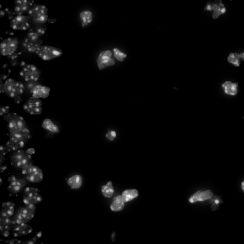

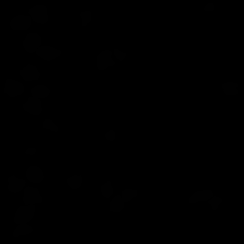

In [176]:
features, labels = get_feeder_method(['./my_first_record.tfrecord'])()

with tf.Session() as sess:
  coord = tf.train.Coordinator()
  tf.train.start_queue_runners(sess=sess, coord=coord)
  ftr_val, lbl_val = sess.run([features, labels])

# And un-normalize and plot
ftr_val = np.squeeze(((ftr_val['image'] + 0.5)*255).astype(np.uint8))
lbl_val = np.squeeze(255*lbl_val['mask'].astype(np.uint8))

show_fig(ftr_val)
show_fig(lbl_val)

There is one other pesky thing to take care of. get_feeder_method needs to know the expected shape of the images stored in the tfrecords.<br>
Normally, this not a problem, we did store the dimensions of the images within the tfrecord file. However, when the Estimator starts creating the graph, it won't actually parse that data, thus it does not know before creating the input nodes how large the images are.<br>

This is why it needs to be hardcoded, but that does not really stop us from creating a function that simply fetches the dimensions and returns them. Said method can then be run BEFORE defining the Estimator, thus allowing us to be rather flexibile in what tfrecord dataset we use

In [177]:
def get_tf_record_image_size(tfrecord):
    """Determine the image size in the tfrecords.

    Since Tensorflow wants static shape, it is not possible to infer the size
    of the images dynamically. We therefor read one sample of the record and
    infer the size of the image

    Parameters
    ----------
    tfrecord: str
        Path to a single tfrecord

    Returns
    -------
    shape: tuple
        The shape of the contained image
    """

    # Simply read the first record, only need one sample
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(tf.train.string_input_producer([tfrecord]))
    parsed = parse_single_example(serialized_example)

    the_shape = [parsed['height'], parsed['width']]

    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        tf.train.start_queue_runners(sess=sess, coord=coord)
        shape_val = sess.run(the_shape)
    tf.reset_default_graph()

    return shape_val

# Lets test it
shape = get_tf_record_image_size('./my_first_record.tfrecord')
print("The shape contained within this tfrecord is {}".format(shape))


The shape contained within this tfrecord is [244, 244]INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer, input_producer/RandomShuffle)]]

